# Pipeline acutel

Clustering :

*   Je traite les corpus via vecteurs Tfid ;
*   J'applique la distance euclidienne pour créer la matrice ;
*   J'applique de l'agglomerative clustering ;
*   Je plot un dendrogramme.


Visualisation :

*   On définis les clusters avec la couleur ;
*   On  créé une colonne dans csv avec le type de cluster;
*   On fait mapping des places sur la carte ;


In [1]:
! pip install scikit-learn numpy pandas matplotlib scipy
! pip install geopandas folium geopy


In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc
import numpy as np
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from scipy.spatial.distance import squareform
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

import pandas as pd
import os
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
source_path = "/content/sample_data/Sous_la_cendre_cleaned-merged.csv"
raw_data = pd.read_csv(source_path,encoding='utf-8',index_col=False)
print(raw_data.head())

content_column = raw_data['Content']
corpus = content_column.to_list()

                             Filename Continent             Country  \
0                cendrillon_allemagne     Europe  Allemagne (Grimm)   
1          orpheline_sa_vache_georgie     Europe            Géorgie   
2                     tam_cam_vietnam       Asie            Vietnam   
3  bouleau__merveilleux_carelie_russe        NaN             Russie   
4           petite-vache-terre_alsace     Europe    France (alsace)   

                                             Content          Types_ATU  
0  La femme d'un homme riche tomba malade et, sen...              510 A  
1  Qu'y avait-il ou que n'y avait-il pas, qu'y a-...  511 + 480 + 510 A  
2  Tam et Câm\nVietnam\nDepuis quand le gâteau de...      510 A + 403 B  
3  Il était une fois un homme et une femme qui av...      510 A + 403 B  
4  Un homme bon et pauvre avait une femme qui lui...          327 + 511  


# Vectorisation



On peut jouer avec els vectors pour voir ce qui est plus représentatif

In [5]:
vect = TfidfVectorizer(min_df=1)
tfidf = vect.fit_transform(corpus)
euclidian = euclidean_distances(tfidf)

# Clustering and plotting

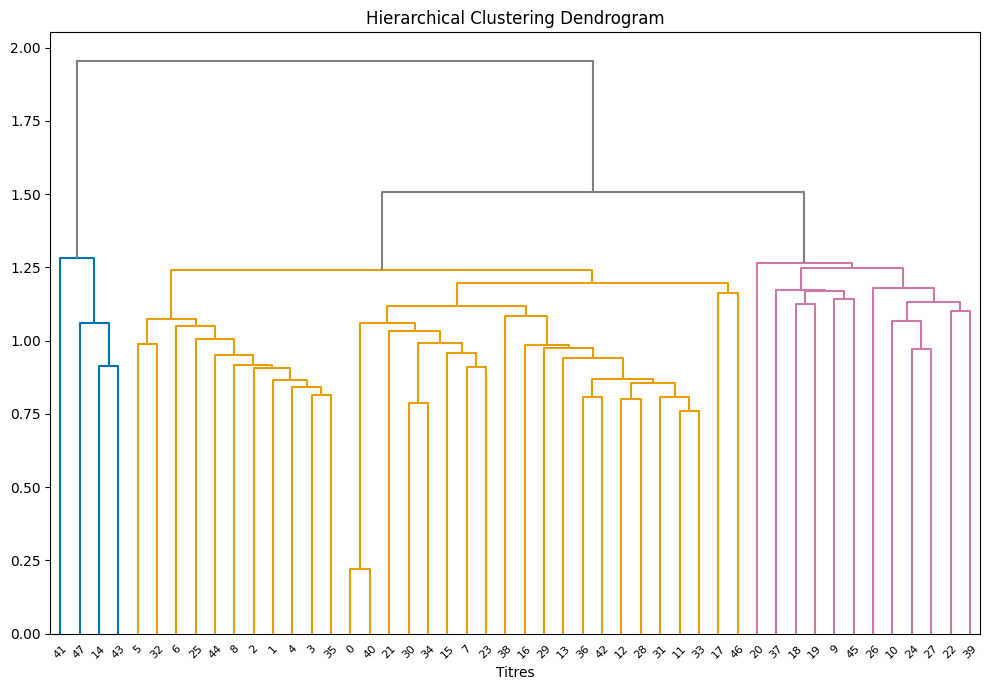

In [6]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import matplotlib.pyplot as plt
import matplotlib as mpl

cb_palette = ['#0072B2', '#E69F00', '#CC79A7']  # Blue, Gold, Purple

plt.figure(figsize=(10, 7))
linkage_matrix = linkage(tfidf.toarray(), method='ward')


def color_palette(*args, **kwargs):
    return mpl.colors.ListedColormap(cb_palette)
dendrogram(
    linkage_matrix,
    labels=raw_data.index,
    color_threshold=1.5,
    above_threshold_color='#808080',
    leaf_font_size=8,
    leaf_rotation=45,
    leaf_label_func=lambda v: str(raw_data.index[v]),
)

for c, pi in zip(cb_palette, plt.gca().collections):
    pi.set_color(c)

plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Titres")
plt.tight_layout()
plt.show()


In [7]:
cluster_labels = fcluster(linkage_matrix, t=3, criterion='maxclust')
raw_data['ID'] = range(len(raw_data))
raw_data['Aggl_cluster'] = cluster_labels - 1

# Use colorblind-friendly color scheme with descriptive names
# These combinations are typically easier to distinguish for most types of colorblindness
cluster_names = {0: "Blue", 1: "Gold", 2: "Purple"}
raw_data['Aggl_cluster'] = raw_data['Aggl_cluster'].map(cluster_names)




raw_data.columns = raw_data.columns.str.strip()  # Remove leading/trailing spaces from column names
raw_data = raw_data[['ID', 'Filename', 'Continent','Country', 'Content', 'Types_ATU', 'Aggl_cluster']]

print(raw_data.head())

   ID                            Filename Continent            Country  \
0   0                cendrillon_allemagne    Europe  Allemagne (Grimm)   
1   1          orpheline_sa_vache_georgie    Europe            Géorgie   
2   2                     tam_cam_vietnam      Asie            Vietnam   
3   3  bouleau__merveilleux_carelie_russe       NaN             Russie   
4   4           petite-vache-terre_alsace    Europe    France (alsace)   

                                             Content          Types_ATU  \
0  La femme d'un homme riche tomba malade et, sen...              510 A   
1  Qu'y avait-il ou que n'y avait-il pas, qu'y a-...  511 + 480 + 510 A   
2  Tam et Câm\nVietnam\nDepuis quand le gâteau de...      510 A + 403 B   
3  Il était une fois un homme et une femme qui av...      510 A + 403 B   
4  Un homme bon et pauvre avait une femme qui lui...          327 + 511   

  Aggl_cluster  
0         Gold  
1         Gold  
2         Gold  
3         Gold  
4         Gold  


In [8]:
raw_data.to_csv("clustered_data.csv", index=False)


______

# Geolocalisation part


In [9]:
import folium
from geopy.geocoders import Nominatim
import pandas as pd
import random
import math
import time
from folium.plugins import MarkerCluster

df = pd.read_csv('clustered_data.csv')

# country mapping
country_map = {
    "Allemagne (Grimm)": "Germany",
    "Géorgie": "Georgia",
    "Vietnam": "Vietnam",
    "Russie": "Russia",
    "France (alsace)": "Grand Est, France",
    "Laponie": "Lapland, Finland",
    "Islande": "Iceland",
    "Italie": "Italy",
    "Tibet": "Tibet, China",
    "France (Pyrenees)": "Occitanie, France",
    "Acadie": "Nova Scotia, Canada",
    "Canada (Algonquin)": "Algonquin Provincial Park, Ontario, Canada",
    "Canada (Nouveau-Brunswick)": "New Brunswick, Canada",
    "Italie (Sardaigne)": "Sardinia, Italy",
    "Indiens Zuñi": "Zuni Pueblo, New Mexico, USA",
    "Grèce": "Greece",
    "Zaïre (Congo)": "Democratic Republic of the Congo",
    "France (Corse)": "Corsica, France",
    "Québec": "Quebec, Canada",
    "Égypte": "Egypt",
    "Angleterre (C. Dickens)": "England, United Kingdom",
    "Chine": "China",
    "Espagne": "Spain",
    "Kabylie": "Kabylie, Algeria",
    "Maroc": "Morocco",
    "Japon": "Japan",
    "Missouri": "Missouri, USA",
    "Danemark": "Denmark",
    "Bas-Poitou": "Poitou, France",
    "Guadeloupe": "Guadeloupe, France",
    "La Mauricie": "Mauricie, Quebec, Canada",
    "France Albert": "Albert, Hauts-de-France, France",
    "France (Nivernais, Morvan)": "Bourgogne-Franche-Comté, France"
}


geolocator = Nominatim(user_agent="folklore_map", timeout=15)

geocode_cache = {}

def geocode_with_retry(location, max_retries=3):
    """
    Pour remedier au problème de timeouts
    """
    if location in geocode_cache:
        return geocode_cache[location]

    for attempt in range(max_retries):
        try:
            result = geolocator.geocode(location)
            if result:
                geocode_cache[location] = (result.latitude, result.longitude)
                return result.latitude, result.longitude
            time.sleep(1 * (attempt + 1))
        except Exception as e:
            print(f"Error geocoding {location} (attempt {attempt+1}): {e}")
            time.sleep(2 * (attempt + 1))

    print(f"Failed to geocode {location} after {max_retries} attempts")
    return None, None

def spiralize_points(center_lat, center_lon, num_points, start_radius=0.5, spiral_factor=0.1):
    """
    Generate points in a spiral pattern around a center point
    helps to distribute multiple items at the same location
    """
    points = []
    for i in range(num_points):
        # Calculate spiral angle and radius
        angle = i * 2.5
        radius = start_radius + (spiral_factor * i)
        angle_rad = math.radians(angle)
        lat_offset = radius * math.sin(angle_rad) * 0.01 # calculating offsets
        lon_offset = radius * math.cos(angle_rad) * 0.01

        points.append((center_lat + lat_offset, center_lon + lon_offset))

    return points

df['Normalized_Country'] = df['Country'].map(lambda x: country_map.get(x, x))
country_counts = df['Normalized_Country'].value_counts().to_dict()
location_coordinates = {}
for country in df['Normalized_Country'].unique():
    if pd.notna(country):
        lat, lon = geocode_with_retry(country)
        if lat and lon:
            location_coordinates[country] = (lat, lon)

m = folium.Map(location=[30, 10], zoom_start=2)

cluster_colors = {
    "Gold": "gold",
    "Purple": "purple",
    "Blue": "blue"
}

processed_locations = {}
for country, count in country_counts.items():
    if country in location_coordinates:
        center_lat, center_lon = location_coordinates[country]
        if count > 1:
            spiral_points = spiralize_points(center_lat, center_lon, count)
            processed_locations[country] = spiral_points
        else:
            processed_locations[country] = [(center_lat, center_lon)]

successfully_mapped = []
failed_to_map = []

for idx, row in df.iterrows():
    country = row['Normalized_Country']
    if country in processed_locations and processed_locations[country]:
        lat, lon = processed_locations[country].pop(0)
        color = cluster_colors.get(row['Aggl_cluster'], 'gray')

        # Add a CircleMarker with popup information
        folium.CircleMarker(
            location=[lat, lon],
            radius=8,
            color=color,
            fill=True,
            fill_color=color,
            fill_opacity=0.7,
            popup=f"ID: {row['ID']}<br>Country: {row['Country']}<br>Continent: {row['Continent']}<br>Aggl_cluster: {row['Aggl_cluster']}<br>ATU_type: {row['Types_ATU']}"
        ).add_to(m)

        successfully_mapped.append({
          'ID': row['ID'],
          'Country': row['Country'],
          'Normalized_Country': country,
          'Continent': row['Continent'],
          'Latitude': lat,
          'Longitude': lon,
          'Aggl_cluster': row['Aggl_cluster'],
          'Types_ATU': row['Types_ATU'],
      })
    else:
        failed_to_map.append({
            'ID': row['ID'],
            'Country': row['Country'],
            'Normalized_Country': country
        })

legend_html = '''
<div style="position: fixed;
            bottom: 50px; right: 50px;
            border:2px solid grey; z-index:9999;
            background-color:white;
            padding: 10px;
            font-size: 14px;">
&nbsp; <b>Clusters</b> <br>
&nbsp; <i class="fa fa-circle" style="color:gold"></i>&nbsp; Gold <br>
&nbsp; <i class="fa fa-circle" style="color:purple"></i>&nbsp; Purple <br>
&nbsp; <i class="fa fa-circle" style="color:blue"></i>&nbsp; Blue <br>
</div>
'''
m.get_root().html.add_child(folium.Element(legend_html))

if successfully_mapped:
    mapped_df = pd.DataFrame(successfully_mapped)
    total_points = len(df)
    mapped_points = len(successfully_mapped)
    print(f"Successfully geocoded {mapped_points} out of {total_points} points ({mapped_points/total_points*100:.1f}%)")
    print("\nID to Location Mapping Table:")
    location_table = mapped_df[['ID', 'Country', 'Normalized_Country', 'Continent', 'Latitude', 'Longitude', 'Aggl_cluster', 'Types_ATU']]
    print(location_table.to_string(index=False))
    location_table.to_csv('location_mapping.csv', index=False)


if failed_to_map:
    print(f"\nFailed to geocode {len(failed_to_map)} locations:")
    for item in failed_to_map:
        print(f"ID: {item['ID']}, Country: {item['Country']}")

m.save('folklore_cluster_map.html')
print("\nMap saved as 'folklore_cluster_map.html'")

m

Successfully geocoded 48 out of 48 points (100.0%)

ID to Location Mapping Table:
 ID                    Country                         Normalized_Country Continent  Latitude   Longitude Aggl_cluster           Types_ATU
  0          Allemagne (Grimm)                                    Germany    Europe 51.163818   10.447831         Gold               510 A
  1                    Géorgie                                    Georgia    Europe 32.329381  -83.113737         Gold   511 + 480 + 510 A
  2                    Vietnam                                    Vietnam      Asie 15.926666  107.965086         Gold       510 A + 403 B
  3                     Russie                                     Russia       NaN 64.686314   97.745306         Gold       510 A + 403 B
  4            France (alsace)                          Grand Est, France    Europe 48.484516    6.113035         Gold           327 + 511
  5                    Laponie                           Lapland, Finland    Europe 

______

# Voir évaluation

L'idée est d'évaluer la corrélation entre les clusters formés et les catégories ATU définies.

## Méthodes d'évaluation

### 1. Indice de Jaccard

L'indice de Jaccard mesure la similarité entre deux ensembles en calculant le rapport entre leur intersection et leur union :

```
Jaccard(A, B) = |A ∩ B| / |A ∪ B|
```

Dans notre contexte, on mesure la similarité entre les ensembles de types ATU présents dans différents clusters.

Un indice proche de 1 = forte similarité (beaucoup de types ATU communs), indice proche de 0 = faible similarité.

### 2. Score de pureté

Le score de pureté évalue dans quelle mesure une catégorie est concentrée dans un seul cluster. Nous calculons :

```
Pureté(ATU) = max(nombre d'occurrences de l'ATU dans un cluster) / nombre total d'occurrences de l'ATU
```

Un score de pureté de 1.0 signifie que le type ATU apparaît exclusivement dans un seul cluster. Le score de pureté global est la moyenne des scores de pureté pour tous les types ATU.

### 3. Précision, Rappel et F1-Score

Où :
- TP (vrais positifs) : textes dans ce cluster avec ce type ATU,
- FP (faux positifs) : textes dans ce cluster sans ce type ATU,
- FN (faux négatifs) : textes avec ce type ATU mais dans d'autres clusters

### 4. Distribution des types ATU

Distribution de chaque type ATU à travers les clusters pour voir :

- catégories dominants dans chaque cluster,
- catégories exclusives à certains clusters,
- Les schémas de co-occurrence entre catégories

### 5. Matrice de co-occurrence

Cette matrice montre la fréquence à laquelle deux types ATU apparaissent ensemble dans les mêmes textes. Je sais pas si c'est utile, vu qu'il existe des textes avec 3 types ATU.


In [10]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from scipy.cluster.hierarchy import dendrogram, linkage
import warnings
warnings.filterwarnings('ignore')

Distribution des clusters:
Aggl_cluster
Gold      32
Purple    12
Blue       4
Name: count, dtype: int64

Types ATU uniques trouvés après normalisation (8):
['327', '403A', '403B', '480', '510A', '510B', '511', '511B']

Types ATU dominants par cluster:
Gold: 510A (27), 511 (8), 403B (6)
Purple: 510A (12), 480 (3), 403B (1)
Blue: 510A (4)

Matrice de similarité de Jaccard entre clusters (basée sur les types ATU):
         Gold    Purple      Blue
Gold    1.000  0.375000  0.125000
Purple  0.375  1.000000  0.333333
Blue    0.125  0.333333  1.000000


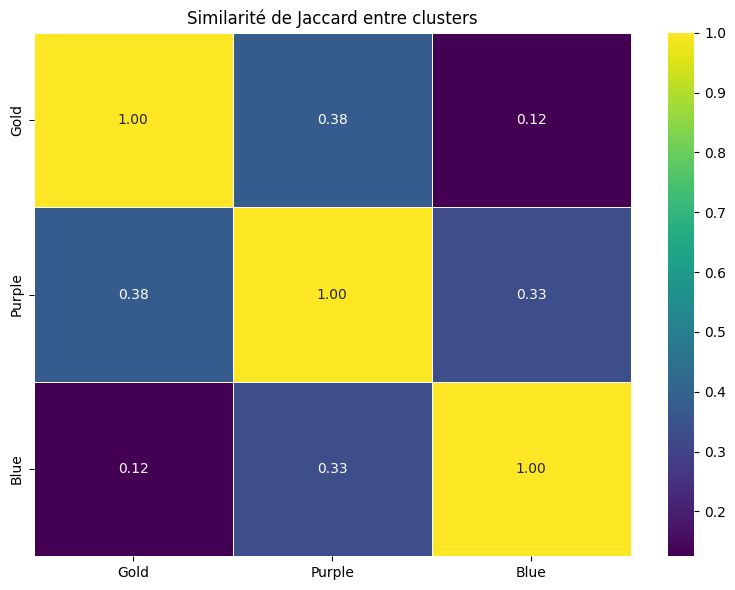


Distribution des types ATU à travers les clusters:
510A: Total 43 - Gold: 27 (62.8%), Purple: 12 (27.9%), Blue: 4 (9.3%)
511: Total 8 - Gold: 8 (100.0%), Purple: 0 (0.0%), Blue: 0 (0.0%)
403B: Total 7 - Gold: 6 (85.7%), Purple: 1 (14.3%), Blue: 0 (0.0%)
480: Total 7 - Gold: 4 (57.1%), Purple: 3 (42.9%), Blue: 0 (0.0%)
510B: Total 2 - Gold: 2 (100.0%), Purple: 0 (0.0%), Blue: 0 (0.0%)
511B: Total 1 - Gold: 1 (100.0%), Purple: 0 (0.0%), Blue: 0 (0.0%)
327: Total 1 - Gold: 1 (100.0%), Purple: 0 (0.0%), Blue: 0 (0.0%)
403A: Total 1 - Gold: 1 (100.0%), Purple: 0 (0.0%), Blue: 0 (0.0%)

Score de pureté global: 0.8821
Scores de pureté par type ATU (triés):
511B: 1.0000
511: 1.0000
327: 1.0000
510B: 1.0000
403A: 1.0000
403B: 0.8571
510A: 0.6279
480: 0.5714


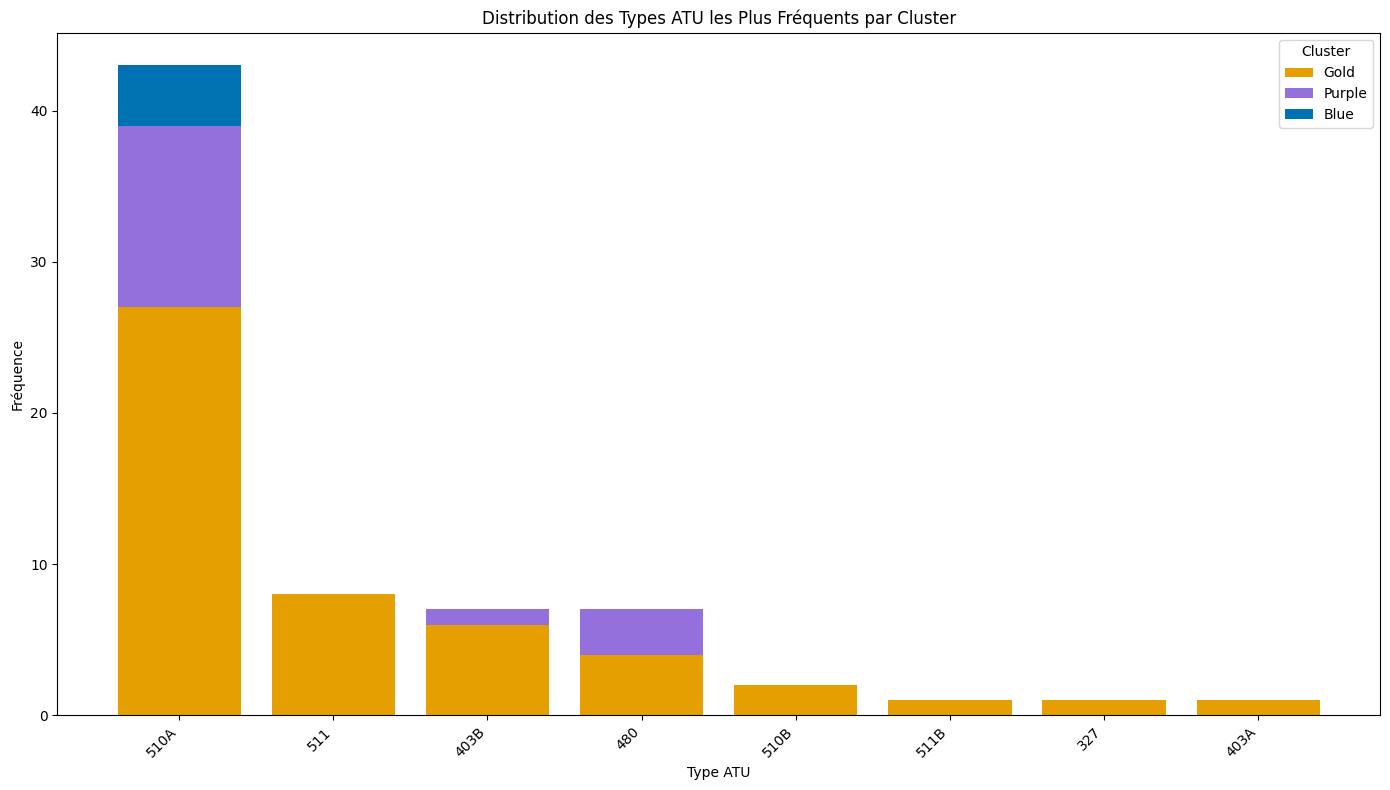


Précision, Rappel et F1 pour les types ATU principaux par cluster:

Type ATU: 510A (Total: 43)
  Gold: P=0.84, R=0.63, F1=0.72
  Purple: P=1.00, R=0.28, F1=0.44
  Blue: P=1.00, R=0.09, F1=0.17

Type ATU: 511 (Total: 8)
  Gold: P=0.25, R=1.00, F1=0.40
  Purple: P=0.00, R=0.00, F1=0.00
  Blue: P=0.00, R=0.00, F1=0.00

Type ATU: 403B (Total: 7)
  Gold: P=0.19, R=0.86, F1=0.31
  Purple: P=0.08, R=0.14, F1=0.11
  Blue: P=0.00, R=0.00, F1=0.00

Type ATU: 480 (Total: 7)
  Gold: P=0.12, R=0.57, F1=0.21
  Purple: P=0.25, R=0.43, F1=0.32
  Blue: P=0.00, R=0.00, F1=0.00

Type ATU: 510B (Total: 2)
  Gold: P=0.06, R=1.00, F1=0.12
  Purple: P=0.00, R=0.00, F1=0.00
  Blue: P=0.00, R=0.00, F1=0.00

Types ATU exclusifs au cluster Gold: 511B, 511, 327, 510B, 403A

Création d'une matrice de co-occurrence des types ATU...


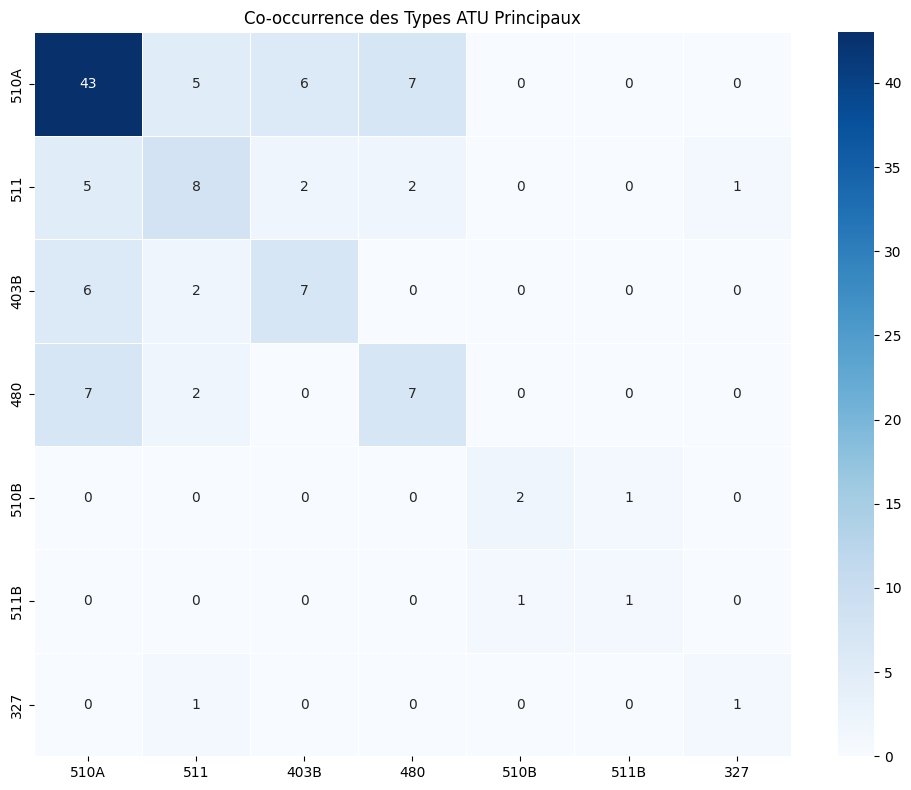

Matrice de co-occurrence créée et visualisée.


In [11]:
raw_data = pd.read_csv('clustered_data.csv')

# Nombre d'éléments par cluster
cluster_counts = raw_data['Aggl_cluster'].value_counts()
print("Distribution des clusters:")
print(cluster_counts)

def normalize_atu_type(atu_type):
    """
    Normalise un type ATU en supprimant les espaces
    """
    if not isinstance(atu_type, str):
        return atu_type
    return ''.join(atu_type.split())

def parse_atu_types(atu_string):
    """
    Analyser une chaîne de types ATU en ensemble de types individuels
    avec normalisation pour éliminer les problèmes d'espaces
    """
    if not isinstance(atu_string, str) or pd.isna(atu_string):
        return set()

    # Diviser par '+' et normaliser en supprimant les espaces entre chiffres et lettres
    types = set()
    for t in atu_string.split('+'):
        # Normaliser en supprimant tous les espaces
        normalized_type = normalize_atu_type(t.strip())
        types.add(normalized_type)

    return types

def calculate_jaccard_index(set1, set2):
    """
    Calculer l'indice de Jaccard entre deux ensembles
    """
    if not set1 and not set2:  # Les deux ensembles sont vides
        return 1.0

    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union

# Extraire tous les types ATU uniques avec normalisation
all_atu_types = set()
for atu_string in raw_data['Types_ATU'].dropna():
    types = parse_atu_types(atu_string)
    all_atu_types.update(types)

print(f"\nTypes ATU uniques trouvés après normalisation ({len(all_atu_types)}):")
print(sorted(all_atu_types))

# Calculer la fréquence de chaque type ATU par cluster
clusters = raw_data['Aggl_cluster'].unique()
cluster_atu_frequency = {cluster: {atu_type: 0 for atu_type in all_atu_types} for cluster in clusters}

for _, row in raw_data.iterrows():
    if pd.notna(row['Types_ATU']):
        types = parse_atu_types(row['Types_ATU'])
        for atu_type in types:
            cluster_atu_frequency[row['Aggl_cluster']][atu_type] += 1

# Afficher les types ATU dominants par cluster
print("\nTypes ATU dominants par cluster:")
for cluster in clusters:
    sorted_types = sorted(
        cluster_atu_frequency[cluster].items(),
        key=lambda x: x[1],
        reverse=True
    )
    dominant = [f"{t[0]} ({t[1]})" for t in sorted_types if t[1] > 0][:3]
    print(f"{cluster}: {', '.join(dominant)}")

# Calculer la matrice de similarité de Jaccard entre les clusters
cluster_atu_sets = {}
for cluster in clusters:
    cluster_data = raw_data[raw_data['Aggl_cluster'] == cluster]
    atu_set = set()

    for atu_string in cluster_data['Types_ATU'].dropna():
        atu_set.update(parse_atu_types(atu_string))

    cluster_atu_sets[cluster] = atu_set

jaccard_matrix = pd.DataFrame(index=clusters, columns=clusters)
for i in clusters:
    for j in clusters:
        jaccard_index = calculate_jaccard_index(cluster_atu_sets[i], cluster_atu_sets[j])
        jaccard_matrix.loc[i, j] = jaccard_index

jaccard_matrix = jaccard_matrix.astype(float)

print("\nMatrice de similarité de Jaccard entre clusters (basée sur les types ATU):")
print(jaccard_matrix)

# Visualiser la matrice de similarité de Jaccard
plt.figure(figsize=(8, 6))
sns.heatmap(
    jaccard_matrix,
    annot=True,
    cmap='viridis',
    fmt='.2f',
    linewidths=.5
)
plt.title('Similarité de Jaccard entre clusters')
plt.tight_layout()
plt.savefig('jaccard_heatmap.png')
plt.show()

# Calculer la distribution des types ATU à travers les clusters
atu_distribution = {atu_type: {'total': 0} for atu_type in all_atu_types}
for cluster in clusters:
    for atu_type in all_atu_types:
        atu_distribution[atu_type][cluster] = 0

for _, row in raw_data.iterrows():
    if pd.notna(row['Types_ATU']):
        types = parse_atu_types(row['Types_ATU'])
        for atu_type in types:
            atu_distribution[atu_type]['total'] += 1
            atu_distribution[atu_type][row['Aggl_cluster']] += 1

# Calculer les pourcentages
for atu_type in all_atu_types:
    for cluster in clusters:
        if atu_distribution[atu_type]['total'] > 0:
            atu_distribution[atu_type][f'{cluster}_pct'] = (
                atu_distribution[atu_type][cluster] / atu_distribution[atu_type]['total'] * 100
            )
        else:
            atu_distribution[atu_type][f'{cluster}_pct'] = 0

# Afficher la distribution des types ATU à travers les clusters
print("\nDistribution des types ATU à travers les clusters:")
sorted_atu_types = sorted(
    atu_distribution.items(),
    key=lambda x: x[1]['total'],
    reverse=True
)

for atu_type, counts in sorted_atu_types:
    distribution_str = ", ".join(
        f"{cluster}: {counts[cluster]} ({counts[f'{cluster}_pct']:.1f}%)"
        for cluster in clusters
    )
    print(f"{atu_type}: Total {counts['total']} - {distribution_str}")

# Calculer la matrice de contingence pour les scores de pureté
contingency_matrix = {atu_type: {cluster: 0 for cluster in clusters} for atu_type in all_atu_types}

for _, row in raw_data.iterrows():
    if pd.notna(row['Types_ATU']):
        types = parse_atu_types(row['Types_ATU'])
        for atu_type in types:
            contingency_matrix[atu_type][row['Aggl_cluster']] += 1

# Calculer la pureté pour chaque type ATU
purity_by_type = {}
for atu_type in all_atu_types:
    max_count = max(contingency_matrix[atu_type].values())
    total_for_type = sum(contingency_matrix[atu_type].values())
    purity_by_type[atu_type] = max_count / total_for_type if total_for_type > 0 else 0

# Calculer la pureté globale
overall_purity = sum(purity_by_type.values()) / len(purity_by_type) if purity_by_type else 0

# Afficher les scores de pureté
print(f"\nScore de pureté global: {overall_purity:.4f}")
print("Scores de pureté par type ATU (triés):")
sorted_purity = sorted(
    purity_by_type.items(),
    key=lambda x: x[1],
    reverse=True
)
for atu_type, purity in sorted_purity:
    print(f"{atu_type}: {purity:.4f}")

# Visualiser la distribution des types ATU par cluster
plt.figure(figsize=(14, 8))
# Préparer les données pour un diagramme à barres empilées
atu_names = [atu_type for atu_type, _ in sorted_atu_types[:9]]  # Top 9 types ATU pour la lisibilité
cluster_data = {
    cluster: [dist[cluster] for atu_type, dist in sorted_atu_types[:9]]
    for cluster in clusters
}

# Créer un diagramme à barres empilées
bottom = np.zeros(len(atu_names))
cluster_colors = {'Gold': '#E69F00', 'Purple': '#9370DB', 'Blue': '#0072B2'}

for cluster in clusters:
    plt.bar(
        atu_names,
        cluster_data[cluster],
        bottom=bottom,
        label=cluster,
        color=cluster_colors.get(cluster, 'gray')
    )
    bottom += np.array(cluster_data[cluster])

plt.xlabel('Type ATU')
plt.ylabel('Fréquence')
plt.title('Distribution des Types ATU les Plus Fréquents par Cluster')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Cluster')
plt.tight_layout()
plt.savefig('atu_distribution.png')
plt.show()

# Calculer la précision, le rappel et le F1-score pour chaque type ATU dans chaque cluster
prf_results = {}
for atu_type in all_atu_types:
    prf_results[atu_type] = {}

    for cluster in clusters:
        tp = 0  # vrais positifs : récits dans ce cluster avec ce type ATU
        fp = 0  # faux positifs : récits dans ce cluster sans ce type ATU
        fn = 0  # faux négatifs : récits pas dans ce cluster mais avec ce type ATU

        for _, row in raw_data.iterrows():
            has_type = pd.notna(row['Types_ATU']) and normalize_atu_type(atu_type) in {normalize_atu_type(t) for t in parse_atu_types(row['Types_ATU'])}
            in_cluster = row['Aggl_cluster'] == cluster

            if has_type and in_cluster:
                tp += 1
            elif not has_type and in_cluster:
                fp += 1
            elif has_type and not in_cluster:
                fn += 1

        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        prf_results[atu_type][cluster] = {'precision': precision, 'recall': recall, 'f1': f1}

print("\nPrécision, Rappel et F1 pour les types ATU principaux par cluster:")
for atu_type, counts in sorted_atu_types[:5]:  # Top 5 types ATU
    print(f"\nType ATU: {atu_type} (Total: {counts['total']})")
    for cluster in clusters:
        metrics = prf_results[atu_type][cluster]
        print(f"  {cluster}: P={metrics['precision']:.2f}, R={metrics['recall']:.2f}, F1={metrics['f1']:.2f}")

# Trouver les types ATU exclusifs à chaque cluster
for cluster in clusters:
    exclusive_types = []
    for atu_type in all_atu_types:
        if (atu_distribution[atu_type][cluster] > 0 and
            sum(atu_distribution[atu_type][c] for c in clusters if c != cluster) == 0):
            exclusive_types.append(atu_type)

    if exclusive_types:
        print(f"\nTypes ATU exclusifs au cluster {cluster}: {', '.join(exclusive_types)}")

try:
    print("\nCréation d'une matrice de co-occurrence des types ATU...")
    cooccurrence_matrix = pd.DataFrame(0, index=sorted(all_atu_types), columns=sorted(all_atu_types))

    for _, row in raw_data.iterrows():
        if pd.isna(row['Types_ATU']):
            continue

        types = list(parse_atu_types(row['Types_ATU']))
        for i in range(len(types)):
            for j in range(i, len(types)):
                cooccurrence_matrix.loc[types[i], types[j]] += 1
                if i != j:
                    cooccurrence_matrix.loc[types[j], types[i]] += 1

    top_types = [atu_type for atu_type, _ in sorted_atu_types[:7]]
    co_matrix_subset = cooccurrence_matrix.loc[top_types, top_types]

    plt.figure(figsize=(10, 8))
    sns.heatmap(
        co_matrix_subset.astype(float),  # Conversion explicite en float
        annot=True,
        cmap='Blues',
        fmt='g',
        linewidths=.5
    )
    plt.title('Co-occurrence des Types ATU Principaux')
    plt.tight_layout()
    plt.savefig('atu_cooccurrence.png')
    plt.show()

    print("Matrice de co-occurrence créée et visualisée.")
except Exception as e:
    print(f"Erreur lors de la création de la matrice de co-occurrence: {str(e)}")